<a href="https://colab.research.google.com/github/mcagriaksoy/squeezeNet_keras_transferLearning/blob/main/squeezeNet_keras_tl_cifar10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


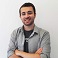

2022 - Created By Mehmet Çağrı Aksoy

https://orcid.org/0000-0002-7886-7945

https://www.researchgate.net/profile/Mehmet-Aksoy-12

https://github.com/mcagriaksoy

https://www.linkedin.com/in/mcagriaksoy/

https://scholar.google.com/citations?user=CKRkg1EAAAAJ&hl=en&oi=ao

In [ ]:
from keras.datasets import cifar10

In [ ]:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()


# **Original SqueezeNet solution**

Optimized for keras new version and google colaboratory environment

The original file (not uptodate) is in rcmalli's repo which is: https://github.com/rcmalli/keras-squeezenet

Changes of rcmalli's version:

*   warnings call removed.
*   get_source_inputs lib call is changed.
*   include_top==True check is added which is already in pull_request in repo.



In [ ]:
from keras import backend as K
from keras.layers import Input, Convolution2D, MaxPooling2D, Activation, concatenate, Dropout
from keras.layers import GlobalAveragePooling2D, GlobalMaxPooling2D
from keras.models import Model
from keras.utils.layer_utils import get_source_inputs #https://stackoverflow.com/questions/68862735/keras-vggface-no-module-named-keras-engine-topology
from tensorflow.keras.utils import get_file
from keras.utils import layer_utils


sq1x1 = "squeeze1x1"
exp1x1 = "expand1x1"
exp3x3 = "expand3x3"
relu = "relu_"

WEIGHTS_PATH = "https://github.com/rcmalli/keras-squeezenet/releases/download/v1.0/squeezenet_weights_tf_dim_ordering_tf_kernels.h5"
WEIGHTS_PATH_NO_TOP = "https://github.com/rcmalli/keras-squeezenet/releases/download/v1.0/squeezenet_weights_tf_dim_ordering_tf_kernels_notop.h5"

# Modular function for Fire Node

def fire_module(x, fire_id, squeeze=16, expand=64):
    s_id = 'fire' + str(fire_id) + '/'

    if K.image_data_format() == 'channels_first':
        channel_axis = 1
    else:
        channel_axis = 3
    
    x = Convolution2D(squeeze, (1, 1), padding='valid', name=s_id + sq1x1)(x)
    x = Activation('relu', name=s_id + relu + sq1x1)(x)

    left = Convolution2D(expand, (1, 1), padding='valid', name=s_id + exp1x1)(x)
    left = Activation('relu', name=s_id + relu + exp1x1)(left)

    right = Convolution2D(expand, (3, 3), padding='same', name=s_id + exp3x3)(x)
    right = Activation('relu', name=s_id + relu + exp3x3)(right)

    x = concatenate([left, right], axis=channel_axis, name=s_id + 'concat')
    return x


# Original SqueezeNet from paper.
def SqueezeNet(include_top=True, weights='imagenet',
               input_tensor=None, input_shape=None,
               pooling=None,
               classes=1000):
    """Instantiates the SqueezeNet architecture."""
        
    if weights not in {'imagenet', None}:
        raise ValueError('The `weights` argument should be either '
                         '`None` (random initialization) or `imagenet` '
                         '(pre-training on ImageNet).')

    if weights == 'imagenet' and classes != 1000 and include_top==True:
        raise ValueError('If using `weights` as imagenet with `include_top`'
                         ' as true, `classes` should be 1000')

    input_shape = input_shape

    if input_tensor is None:
        img_input = Input(shape=input_shape)
    else:
        if not K.is_keras_tensor(input_tensor):
            img_input = Input(tensor=input_tensor, shape=input_shape)
        else:
            img_input = input_tensor


    x = Convolution2D(64, (3, 3), strides=(2, 2), padding='valid', name='conv1')(img_input)
    x = Activation('relu', name='relu_conv1')(x)
    x = MaxPooling2D(pool_size=(3, 3), strides=(2, 2), name='pool1')(x)

    x = fire_module(x, fire_id=2, squeeze=16, expand=64)
    x = fire_module(x, fire_id=3, squeeze=16, expand=64)
    x = MaxPooling2D(pool_size=(3, 3), strides=(2, 2), name='pool3')(x)

    x = fire_module(x, fire_id=4, squeeze=32, expand=128)
    x = fire_module(x, fire_id=5, squeeze=32, expand=128)
    x = MaxPooling2D(pool_size=(3, 3), strides=(2, 2), name='pool5')(x)

    x = fire_module(x, fire_id=6, squeeze=48, expand=192)
    x = fire_module(x, fire_id=7, squeeze=48, expand=192)
    x = fire_module(x, fire_id=8, squeeze=64, expand=256)
    x = fire_module(x, fire_id=9, squeeze=64, expand=256)
    
    if include_top:
        x = Dropout(0.5, name='drop9')(x)
        x = Convolution2D(classes, (1, 1), padding='valid', name='conv10')(x)
        x = Activation('relu', name='relu_conv10')(x)
        x = GlobalAveragePooling2D()(x)
        x = Activation('softmax', name='loss')(x)
    else:
        if pooling == 'avg':
            x = GlobalAveragePooling2D()(x)
        elif pooling=='max':
            x = GlobalMaxPooling2D()(x)
        elif pooling==None:
            pass
        else:
            raise ValueError("Unknown argument for 'pooling'=" + pooling)

    if input_tensor is not None:
        inputs = get_source_inputs(input_tensor)
    else:
        inputs = img_input

    model = Model(inputs, x, name='squeezenet')

    if weights == 'imagenet':
        if include_top:
            weights_path = get_file('squeezenet_weights_tf_dim_ordering_tf_kernels.h5',
                                    WEIGHTS_PATH,
                                    cache_subdir='models')
        else:
            weights_path = get_file('squeezenet_weights_tf_dim_ordering_tf_kernels_notop.h5',
                                    WEIGHTS_PATH_NO_TOP,
                                    cache_subdir='models')
            
        model.load_weights(weights_path)
        if K.backend() == 'theano':
            layer_utils.convert_all_kernels_in_model(model)

    return model

# **Transfer Learning example:**

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Dropout, Flatten

In [ ]:

NUMBER_OF_CLASSES = 10 # number of unique digits
input_shape = (32,32,3) # cifar10 img size

epochs = 30
batch_size = 64
optimizer = "Adam"

In [ ]:
base_model = SqueezeNet(weights="imagenet", input_shape=input_shape, include_top=False, pooling = 'avg', classes=NUMBER_OF_CLASSES)

for layer in base_model.layers:
    layer.trainable = False

inputs = tf.keras.Input(shape=(input_shape))
x = base_model(inputs, training=False)

predictions = Dense(NUMBER_OF_CLASSES, activation= 'softmax')(x)

SqueezeNet_model = Model(inputs = inputs, outputs = predictions)

SqueezeNet_model.summary()

SqueezeNet_model.compile(
  optimizer= optimizer,
  loss= 'sparse_categorical_crossentropy',
  metrics=['accuracy'])

# Do not forget to change it with your train-test-val files!
history_SqueezeNet_model = SqueezeNet_model.fit(x_train, 
                                                y_train,
                                                validation_data=(x_test,y_test),
                                                epochs=epochs,
                                                batch_size = batch_size
                                                )

### Results Graph Comparison

In [ ]:
plt.plot(history_SqueezeNet_model.history['accuracy'])

plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['SqueezeNet ImageNet weights'], loc='lower right')

# **No weights Example**

In [ ]:
SqueezeNet_model = SqueezeNet(weights=None, input_shape=input_shape, pooling = 'avg', classes=NUMBER_OF_CLASSES)

SqueezeNet_model.summary()

SqueezeNet_model.compile(
  optimizer= optimizer,
  loss= 'sparse_categorical_crossentropy',
  metrics=['accuracy'])

# Do not forget to change it with your train-test-val files!
history_SqueezeNet_model = SqueezeNet_model.fit(x_train,
                                                y_train,
                                                validation_data=(x_test,y_test),
                                                epochs=epochs,
                                                batch_size = batch_size
                                                )